In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [3]:
# First lets look at the ratings.
raw_data.rating.value_counts()

4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [4]:
np.diff(np.array([0.0, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0]))

array([1.25 , 0.625, 0.625, 0.625, 0.625, 0.625, 0.625])

Since the ratings are actually discrete, a classifier makes more sense. Note that the rating levels are not uniformly distributed. 

First lets add a binary feature to indicate if the recipe lists calories that are in the top 75% of all ratings, as well as some group some highly correlated features.

# Split

In [4]:
X = raw_data.dropna().drop(['rating', 'title'], axis = 1)
X_test, X_train, y_test, y_train = train_test_split(X, raw_data.dropna().rating, test_size=0.70)

(array([ 900.,    0.,   92.,   60.,    0.,  281.,  824., 2908., 4593.,
        1447.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

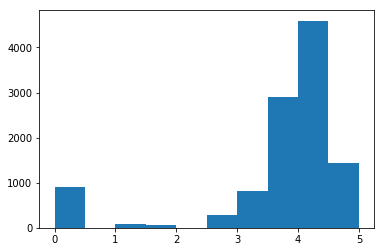

In [5]:
plt.hist(y_train)

In [6]:
# lets see what features are extrmely correlated
cm = X_train.corr()
s = cm.unstack()
so = s[s!=1.0].sort_values(kind="quicksort", ascending=False)
so[so>=0.7]

calories       sodium           0.996547
sodium         calories         0.996547
calories       fat              0.996492
fat            calories         0.996492
               sodium           0.986393
sodium         fat              0.986393
peanut free    soy free         0.940443
soy free       peanut free      0.940443
pescatarian    kosher           0.876206
kosher         pescatarian      0.876206
drink          alcoholic        0.851875
alcoholic      drink            0.851875
snack week     snack            0.819680
snack          snack week       0.819680
tree nut free  peanut free      0.819604
peanut free    tree nut free    0.819604
protein        sodium           0.817770
sodium         protein          0.817770
protein        calories         0.802612
calories       protein          0.802612
tree nut free  soy free         0.787444
soy free       tree nut free    0.787444
illinois       chicago          0.774527
chicago        illinois         0.774527
protein        f

In [7]:
# features to combine* (binary interaction)
features1 = ['calories', 'calories', 'sodium', 'peanut free', 
             'pescatarian', 'drink', 'peanut free', 'portland', 
             'soy free', 'sodium', 'vegetarian', 'snack week', 
             'pescatarian', 'kosher', 'peanut free', 'peanut free', 
             'soy free', 'calories', 'brunch', 'kentucky', 'denver', 
             'louisiana', 'new orleans']

features2 = ['sodium', 'fat', 'fat', 'soy free', 'kosher', 'alcoholic', 
             'tree nut free', 'oregon', 'tree nut free', 'protein', 
             'pescatarian', 'snack', 'soy free', 'vegetarian', 
             'pescatarian', 'kosher', 'kosher', 'protein', 'breakfast', 
             'louisville', 'omelet', 'kitchen olympics', 'louisiana']

for a,b in zip(features1, features2):
    X_train[a + "_" + b] = X_train[a] * X_train[b]
    X_test[a + "_" + b] = X_test[a] * X_test[b]

# Feature Selection  
## Random Forest  

We will first predict how likely the recipe is a high (>=2.5 rating) or low (<2.5), and given this predicted probability we can feed the data to a further model (2 layer).

In [8]:
X_train_dummy = pd.get_dummies(X_train)
# convert all columns to int's and make source_pc binary
X_train_dummy = X_train_dummy.astype(int)

**High or Low rating?** (<= 2.5)

In [9]:
# Features & Target
y_low = y_train <= 2.5

#Pipeline Construction.
anova_low = SelectKBest(f_classif, k=30)
svc_low = SVC(kernel='linear')
anova_svc = make_pipeline(anova_low, svc_low)

In [10]:
#Fitting & Cross-Validation.
anova_svc.fit(X_train_dummy,y_low)
scores_low = cross_val_score(anova_svc, X_train_dummy, y_low, cv=5)

#De-Masking Selected Features.
features_low = anova_low.get_support(indices=True)
selected_features_low = list(X_train_dummy.columns[features_low])

#Printing Outcomes.
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))
print('Selected Features: {}\n'.format(selected_features_low))

Cross-Validation Scores: [0.88388839 0.88433843 0.88698784 0.88153153 0.88423423]
Cross-Validation Score Averaged Across Folds: 88.42%.

Selected Features: ['alcoholic', 'bake', 'bitters', 'bon appétit', 'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'drink', 'fall', 'gin', 'harpercollins', 'house & garden', 'liqueur', 'non-alcoholic', 'peanut free', 'pickles', 'punch', 'rum', 'sauce', 'sauté', 'soy free', 'spirit', 'vegan', 'vermouth', 'weelicious', 'winter', 'leftovers', 'peanut free_soy free', 'drink_alcoholic']



In [11]:
svc_1ow = SVC()
X_low = X_train[selected_features_low]
svc_1ow.fit(X_low,y_low)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [12]:
scores_low = cross_val_score(svc_1ow, X_train[selected_features_low], y_low, cv=5)
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))

Cross-Validation Scores: [0.88748875 0.88388839 0.88698784 0.88198198 0.88513514]
Cross-Validation Score Averaged Across Folds: 88.51%.



In [13]:
y_pred_train = svc_1ow.predict(X_train[selected_features_low]).astype(int)

This model simply predicts if the given recipe will be rated high or low. Let's see how it performs on the test set.  

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9772
           1       0.74      0.07      0.13      1333

   micro avg       0.89      0.89      0.89     11105
   macro avg       0.81      0.53      0.53     11105
weighted avg       0.87      0.89      0.84     11105



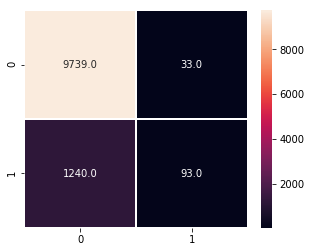

In [16]:
#Clasification report
results_train = metrics.classification_report(y_true=(y_train<=2.5).astype(int), y_pred=y_pred_train)
print(results_train)

#Confusion Matrix
cm_low = metrics.confusion_matrix(y_true=(y_train<=2.5).astype(int), y_pred=y_pred_train)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_low, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

### Evaluation

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4187
           1       0.74      0.08      0.14       572

   micro avg       0.89      0.89      0.89      4759
   macro avg       0.81      0.54      0.54      4759
weighted avg       0.87      0.89      0.84      4759



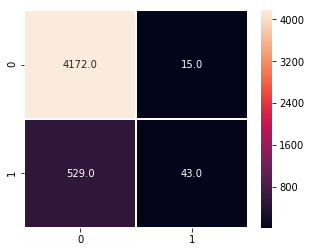

In [17]:
y_pred_test = svc_1ow.predict(X_test[selected_features_low])
#Clasification report
results_test = metrics.classification_report(y_true=(y_test<=2.5).astype(int), y_pred=y_pred_test)
print(results_test)

#Confusion Matrix
cm_test = metrics.confusion_matrix(y_true=(y_test<=2.5).astype(int), y_pred=y_pred_test)
f,ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, linewidths=.5, fmt= '.1f',ax=ax);

## Further classification  
The above model will predict whether or not the given recipe will be a low or high rating. If, instead, we want to predict the overall rating (7 levels from 0 to 5), we can still use a classifier, but this time with 8 possible outcomes. First let's define that mapping.

In [18]:
z = {0.0: 0, 1.25: 1, 1.875: 2, 2.5: 3, 3.125: 4, 3.75: 5, 4.375: 6, 5.0: 7}

In [19]:
# Features & Target
y = y_train.map(z)

#Pipeline Construction.
anova = SelectKBest(f_classif, k=30)
svc = SVC(kernel='linear')
anova_svc = make_pipeline(anova, svc)

#Fitting & Cross-Validation.
anova_svc.fit(X_train_dummy,y)
scores = cross_val_score(anova_svc, X_train_dummy, y, cv=5)
#De-Masking Selected Features.
features = anova.get_support(indices=True)  
selected_features = list(X_train_dummy.columns[features])

#Printing Outcomes.
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))
print('Selected Features: {}\n'.format(selected_features))

Cross-Validation Scores: [0.88748875 0.88388839 0.88698784 0.88198198 0.88513514]
Cross-Validation Score Averaged Across Folds: 88.51%.

Selected Features: ['alcoholic', 'bake', 'bitters', 'bon appétit', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'créme de cacao', 'crêpe', 'drink', 'fall', 'fruit juice', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'lasagna', 'lime juice', 'liqueur', 'non-alcoholic', 'pasta', 'quick & easy', 'rum', 'sauce', 'sauté', 'spirit', 'vegetable', 'winter', 'drink_alcoholic']



In [20]:
svc2 = SVC(probability=True)
X = X_train[selected_features]
svc2.fit(X,y)

scores2 = cross_val_score(svc2, X_train[selected_features], y, cv=5)
print('Cross-Validation Scores: {}'.format(scores2))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores2.mean()))

p_pred = svc2.predict_proba(X_test[selected_features])

Cross-Validation Scores: [0.42940647 0.42735043 0.43628996 0.42767012 0.42605951]
Cross-Validation Score Averaged Across Folds: 42.94%.



In [21]:
y_pred_test = p_pred.argmax(axis=1)
#Clasification report
results = metrics.classification_report(y_true=y_test.map(z), y_pred=y_pred_test)
print(results)

              precision    recall  f1-score   support

           0       0.47      0.30      0.36       396
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00       124
           4       0.00      0.00      0.00       341
           5       0.00      0.00      0.00      1228
           6       0.43      0.98      0.60      1959
           7       0.41      0.01      0.03       659

   micro avg       0.43      0.43      0.43      4759
   macro avg       0.16      0.16      0.12      4759
weighted avg       0.27      0.43      0.28      4759



So this model is only ok with those recipes with a 0, 4.375 or 5 rating, which is likely a result of the original distribution of ratings (as well as other things). These groups have larger sample sizes, but it is interesting to notice that it was unable to classify any review with a rating of 3.75 even though this group has a relatively large group size.

In [89]:
raw_data.rating.value_counts().sort_index()

0.000    1836
1.250     164
1.875     124
2.500     532
3.125    1489
3.750    5169
4.375    8019
5.000    2719
Name: rating, dtype: int64

**Improvements**  

This is a pretty small set of features, try doubling this?

In [24]:
# Features & Target
y = y_train.map(z)

#Pipeline Construction.
anova = SelectKBest(f_classif, k=60)
svc = SVC(kernel='linear')
anova_svc = make_pipeline(anova, svc)

#Fitting & Cross-Validation.
anova_svc.fit(X_train_dummy,y)
scores = cross_val_score(anova_svc, X_train_dummy, y, cv=5)
#De-Masking Selected Features.
features = anova.get_support(indices=True)  
selected_features = list(X_train_dummy.columns[features])

#Printing Outcomes.
print('Cross-Validation Scores: {}'.format(scores_low))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_low.mean()))
print('Selected Features: {}\n'.format(selected_features))

Cross-Validation Scores: [0.88748875 0.88388839 0.88698784 0.88198198 0.88513514]
Cross-Validation Score Averaged Across Folds: 88.51%.

Selected Features: ['alcoholic', 'backyard bbq', 'bake', 'bitters', 'bon appétit', 'brandy', 'bread', 'champagne', 'cheese', 'chicken', 'chile pepper', 'cocktail', 'cocktail party', 'condiment', 'cornmeal', 'créme de cacao', 'crêpe', 'drink', 'fall', 'fortified wine', 'fruit juice', 'gin', 'gourmet', 'harpercollins', 'house & garden', 'lasagna', 'lemon juice', 'lime juice', 'liqueur', 'low cholesterol', 'no sugar added', 'non-alcoholic', 'onion', 'orange juice', 'pasta', 'peanut free', 'pickles', 'punch', 'quick & easy', 'quick and healthy', 'roast', 'rum', 'sauce', 'sauté', 'side', 'soy free', 'spirit', 'thanksgiving', 'tree nut free', 'vegan', 'vegetable', 'vegetarian', 'vermouth', 'vodka', 'weelicious', 'winter', 'leftovers', 'peanut free_soy free', 'drink_alcoholic', 'peanut free_tree nut free']



In [26]:
svc2 = SVC(probability=True)
X = X_train[selected_features]
svc2.fit(X,y)

scores2 = cross_val_score(svc2, X_train[selected_features], y, cv=5)
print('Cross-Validation Scores: {}'.format(scores2))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores2.mean()))

p_pred = svc2.predict_proba(X_test[selected_features])

Cross-Validation Scores: [0.43030576 0.42420153 0.43493922 0.42767012 0.42651037]
Cross-Validation Score Averaged Across Folds: 42.87%.



In [27]:
y_pred_test = p_pred.argmax(axis=1)
#Clasification report
results = metrics.classification_report(y_true=y_test.map(z), y_pred=y_pred_test)
print(results)

              precision    recall  f1-score   support

           0       0.45      0.26      0.33       396
           1       0.00      0.00      0.00        31
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00       124
           4       0.00      0.00      0.00       341
           5       0.33      0.00      0.00      1228
           6       0.42      0.98      0.59      1959
           7       0.22      0.00      0.01       659

   micro avg       0.43      0.43      0.43      4759
   macro avg       0.18      0.16      0.12      4759
weighted avg       0.33      0.43      0.27      4759



So by adding these 30 features we are now able to pick up on the 3.75 rating class, but at the cost of 0 and 5 ratings. LASSO regression might next be used to identify features.  

**LASSO Regression**  

In [40]:
from sklearn.linear_model import LogisticRegression
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
lassoregr = LogisticRegression(penalty ='l1', solver=solvers[4], multi_class='multinomial')
lassoregr.fit(X_train, y_train.map(z))

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [51]:
coeffs = pd.DataFrame(lassoregr.coef_.transpose())
coeffs.index = X_train.columns
coeffs

,0,1,2,3,4,5,6,7
calories,-9.980576e-22,-1.173644e-21,-1.180486e-21,-1.128764e-21,-9.926100e-22,-3.342642e-22,2.307668e-21,3.500160e-21
protein,-3.918569e-23,-4.462204e-23,-4.514650e-23,-4.307765e-23,-3.691815e-23,-6.435165e-24,2.105342e-23,1.943341e-22
fat,-4.461992e-23,-5.328645e-23,-5.337042e-23,-5.069906e-23,-4.298885e-23,-5.347411e-24,1.618871e-22,8.842730e-23
sodium,-1.132785e-21,-1.425945e-21,-1.421294e-21,-1.357832e-21,-1.213062e-21,-1.634740e-22,2.089790e-21,4.624604e-21
#cakeweek,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.850701e-28,0.000000e+00,0.000000e+00
#wasteless,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
22-minute meals,-7.436133e-29,-7.436133e-29,-7.436133e-29,-7.436133e-29,-7.436133e-29,0.000000e+00,1.641791e-27,0.000000e+00
3-ingredient recipes,1.812755e-27,0.000000e+00,-5.143416e-28,-5.143416e-28,0.000000e+00,7.296658e-29,0.000000e+00,0.000000e+00
30 days of groceries,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.312250e-28,0.000000e+00,0.000000e+00
advance prep required,1.743212e-27,-2.339009e-27,-3.447194e-27,-1.728337e-27,-7.262074e-30,2.293851e-27,2.328199e-27,1.154265e-27


It would be easier to visualize if we first converted the above matrix into rankings (along each column). Say we wanted to optimize the model to perform on those recipes with a 3.125 rating, then we take the top k features for the 5th column.

In [53]:
y_train.value_counts().sort_index()

0.000     900
1.250      92
1.875      60
2.500     281
3.125     824
3.750    2908
4.375    4593
5.000    1447
Name: rating, dtype: int64

In [65]:
new_features = coeffs.iloc[:,4].sort_values().index[:29]
# Features & Target
y_new = y_train.map(z)

svc_new = SVC(probability=True)
svc_new.fit(X_train[new_features], y_train.map(z))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [68]:
scores_new = cross_val_score(svc_new, X_train[new_features], y_new, cv=5)
print('Cross-Validation Scores: {}'.format(scores_new))
print('Cross-Validation Score Averaged Across Folds: {:.2%}.\n'.format(scores_new.mean()))

p_pred_new= svc_new.predict_proba(X_test[new_features])

Cross-Validation Scores: [0.47751799 0.48538012 0.46555606 0.47408743 0.47339946]
Cross-Validation Score Averaged Across Folds: 47.52%.



In [80]:
y_pred_new = p_pred_new.argmax(axis=1)
#Clasification report
results_new = metrics.classification_report(y_true=y_test.map(z), y_pred=y_pred_new)
print(results_new)

              precision    recall  f1-score   support

           0       0.84      0.19      0.32       396
           1       1.00      0.10      0.18        31
           2       0.00      0.00      0.00        21
           3       0.89      0.14      0.24       124
           4       0.90      0.11      0.20       341
           5       0.91      0.12      0.21      1228
           6       0.45      0.99      0.62      1959
           7       0.91      0.19      0.32       659

   micro avg       0.49      0.49      0.49      4759
   macro avg       0.74      0.23      0.26      4759
weighted avg       0.71      0.49      0.40      4759



Whoa this set of features appears to improve on all classes (note no change to rating of 1.875).